# Deep learning Basic 

## Scenario

 - Dataset 
 - Loading Dataset file 
 - Building Model 
 - Model Save & Restore
 - Tensorboard 
 
### Learning by implementation 

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import csv

/Users/MAC/.pyenv/versions/anaconda3-5.0.1/envs/python_ana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
samples = 1000 
test_samples = 100 
train_dataset = './ffnn_dataset/train_dataset.csv'
test_dataset = './ffnn_dataset/test_dataset.csv'

def write_dataset(samples, test_samples, train_dir, test_dir):
    up = list(range(10))
    down = list(range(9, -1, -1))
    # up - 1 
    # down - 0
    data = []
    label = []
    # 10 차원의 벡터를 sample수 만큼 데이터 셋에 담고, 
    # 10 차원 벡터의 target을 스칼라 1, 0으로 만들어 준다. 
    for i in range(samples):
        data.append(up)
        data.append(down)
        label.append([1])
        label.append([0])
    
    # samples 에서 test_samples의 개수를 뺀 만큼을 Train,
    # test_samples의 개수 만큼을 Test
    with open(train_dataset, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(samples - test_samples):
            writer.writerow(label[i] + data[i])
        print('train data has been written')

    with open(test_dataset, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(test_samples):
            writer.writerow(label[i] + data[i])
        print('test data has been written')
        
write_dataset(samples, test_samples, train_dataset, test_dataset)

train data has been written
test data has been written


Tensor("Cast:0", shape=(?, 1), dtype=float32)
Tensor("Cast_1:0", shape=(?, 10), dtype=float32)
Tensor("Cast_2:0", shape=(?, 1), dtype=float32)
Tensor("Cast_3:0", shape=(?, 10), dtype=float32)
############### Datasets prepared ###############
reuse : False
layer1 shape (?, 10)
layer2 shape (?, 5)
output shape (?, 1)


reuse : True
layer1 shape (?, 10)
layer2 shape (?, 5)
output shape (?, 1)


epoch: 0, loss : 0.7561835050582886, acc : 0.0
epoch: 100, loss : 0.6722434759140015, acc : 0.5
epoch: 200, loss : 0.5977892279624939, acc : 0.7074999809265137
epoch: 300, loss : 0.5777143836021423, acc : 0.8050000071525574
epoch: 400, loss : 0.5666851997375488, acc : 0.8537499904632568
epoch: 500, loss : 0.5568826198577881, acc : 0.8830000162124634
epoch: 600, loss : 0.5485398173332214, acc : 0.9024999737739563
epoch: 700, loss : 0.5416406393051147, acc : 0.9164285659790039
epoch: 800, loss : 0.5359908938407898, acc : 0.9268749952316284
epoch: 900, loss : 0.5313858389854431, acc : 0.93500000238418

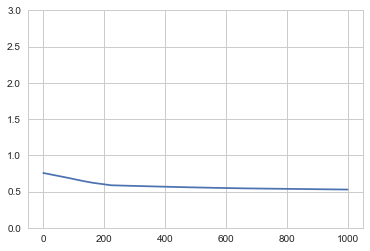

In [4]:
# tensorflow로 개발 하다보면, 이전에 실행했던 그래프가 남아 에러를 낼 때가 있다 
# 자주 graph를 reset해주도록 한다. 
tf.reset_default_graph()

trainset = tf.data.TextLineDataset(train_dataset).batch(batch_size=10).shuffle(777)
testset = tf.data.TextLineDataset(test_dataset).batch(batch_size=10).shuffle(777)
# # 아래와 같이 Dataset을 늘릴 수도 있다. 
trainset = trainset.repeat(100)
testset = testset.repeat(100)

# create iterator
train_itr = trainset.make_one_shot_iterator()
test_itr = testset.make_one_shot_iterator()

train_batch = train_itr.get_next()# iterator가 실행 되면, 다음 것을 가져온다. 
test_batch = test_itr.get_next()
# --> 여기 까지 데이터를 받아오면, 스트링 형태이다 .

train_batch = tf.decode_csv(train_batch, record_defaults=[[0]]*11)
# record_defaluts (리스트로 받는다.)- csv는 정형데이터이다. 
# 따라서, 미싱데이터에 대체 할 defalut 값을 요구한다.  
test_batch = tf.decode_csv(test_batch, [[0]]*11)

# 랭크를 맞춰주기 위해서 아래와 같이 차원을 조정한다. 
train_label = tf.reshape(train_batch[0], [-1, 1])
test_label = tf.reshape(test_batch[0], [-1, 1])

# ## Or
# label = tf.expand_dims(train_batch[0], axis=-1)

# stack 하는 과정에서 axis를 주의하길 바란다. 
train_feature = tf.stack(train_batch[1:], axis=1)
test_feature = tf.stack(test_batch[1:], axis=1)

# casting 을 해주어야 한다.  dtype 을 float 로 
train_label = tf.cast(train_label, tf.float32)
train_feature = tf.cast(train_feature, tf.float32)
test_label = tf.cast(test_label, tf.float32)
test_feature = tf.cast(test_feature, tf.float32)

print(train_label)
print(train_feature)
print(test_label)
print(test_feature)
print("#"*15 + " Datasets prepared " + "#"*15)

############ Modeling 
def binary_model(feature, activation, reuse=False):
    # densenet을 쌓아보자
    layer1 = tf.layers.dense(feature, units=10, 
                             activation=activation,
                             reuse=reuse, name='layer1')
    layer2 = tf.layers.dense(layer1, units=5, 
                             activation=activation,
                             reuse=reuse, name='layer2')
    ## output layer에서 actiavation func은 없다. 
    ##(cross entropyloss에서 자동을 씌워준다.)
    output = tf.layers.dense(layer2, units=1, 
                             reuse=reuse, name='output')
    
    # Debugging 을 위해서 프린트를 해보겠다. 
    print('reuse : {}'.format(reuse))
    print('layer1 shape {}'.format(layer1.shape))
    print('layer2 shape {}'.format(layer2.shape))
    print('output shape {}'.format(output.shape))    
    print("\n")
    
    return output 

train_label_predicted = tf.nn.sigmoid(binary_model(train_feature, 
                                                   activation=tf.nn.relu))

test_label_predicted = tf.nn.sigmoid(binary_model(test_feature, 
                                                  activation=tf.nn.relu, reuse=True))
            #- reuse를 함으로써 train에서 만든 가중치들을 share할 수 있다.
# test를 예측한 결과는 0 또는 1만 답이 되도록 한다. (확률처럼 출력할 수도 있음)
test_label_predicted = tf.round(test_label_predicted)

accuracy = tf.metrics.accuracy(test_label, test_label_predicted)

loss = tf.losses.sigmoid_cross_entropy(train_label, train_label_predicted)

# summary 객체를 생성 \
summary = tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)

# model을 저장 하기 위한 객체 생성 
saver = tf.train.Saver()

########## Run 

with tf.Session() as sess :
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())# for getting Accuracy (이동평균으로 구하기 때문)
    writer = tf.summary.FileWriter('ffnn_dataset/', sess.graph)
    
    loss_graph = []
    for i in range(1000): # 1000epochs 실행 해보자 
        
        _, _loss, _acc, _summ = sess.run([train_op, loss, accuracy, merged])
        loss_graph.append(_loss)
        writer.add_summary(_summ, i)

        if i % 100 == 0:
            print("epoch: {}, loss : {}, acc : {}".format(i, _loss, _acc[0]))

    plt.ylim(0, 3)
#     plt.scatter(np.linspace(0, 100, num=len(loss_graph)), loss_graph, 100, 'g')
    plt.plot(loss_graph)
    print('accuracy : {}'.format(_acc))# [한스텝 전의 accuracy, 한스텝 후의 accuracy]
    saver.save(sess, 'ffnn_dataset/ffnn')

In [6]:
### Model load and predict 

with tf.Session() as sess :
    saver.restore(sess, 'ffnn_dataset/ffnn')
    _pred, _truth = sess.run([test_label_predicted, test_label])
    for l, z in zip(_pred, _truth):
        if l[0] != z[0]:
            print("wrong")
        print("pred:{}, truth:{}".format(l[0], z[0]))

INFO:tensorflow:Restoring parameters from ffnn_dataset/ffnn
pred:1.0, truth:1.0
pred:0.0, truth:0.0
pred:1.0, truth:1.0
pred:0.0, truth:0.0
pred:1.0, truth:1.0
pred:0.0, truth:0.0
pred:1.0, truth:1.0
pred:0.0, truth:0.0
pred:1.0, truth:1.0
pred:0.0, truth:0.0
